In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle
import pandas as pd
import torch
import torch.nn.functional as F
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from utils import *

In [2]:
dataset='users' #dataset name, if adding any new dataset modify the dataset_dict in utils
users_bs=3
univariate='False' #False if multivariate 
model_names=['dlinear','patchtst'] #Select the list of models used on the experiments options:['dlinear','patchtst','tsmixer']
lookback,horizon=60,20 #Use the same values as in run.py
exp_dict={}
X_train,X_test,y_train,y_test=dataset_dict[dataset](lookback,horizon,dataset=dataset,frequency=users_bs,univariate=univariate)
y=y_test.squeeze().numpy()

if dataset=='users':
        dataset=f'users_bs{users_bs}'
for model_name in model_names:
        if univariate=='False':
                model_fname=model_name+'_mv'
        else:
               model_fname=model_name 
        with open(f'./results/configs/{model_fname}_{dataset}_{lookback}_{horizon}_configs.pkl', 'rb') as f:
                configs=pickle.load(f)
        X_test_rs=X_test.reshape(X_test.shape[0],configs.enc_in*configs.seq_len)
        y_test_rs=y_test.reshape(X_test.shape[0],configs.enc_in*configs.pred_len)
        X_test_exp=X_test_rs.unsqueeze(dim=-1).expand(-1,-1,configs.pred_len*configs.enc_in)
        temp_dict={}
        temp_dict['pred_test_rs']=torch.tensor(np.loadtxt(f'./results/predictions/{model_fname}_{dataset}_{lookback}_{horizon}_predictions.txt'))
        temp_dict['pred_test']=temp_dict['pred_test_rs'].reshape(-1,configs.pred_len,configs.enc_in)
        temp_dict['error_test']=y_test.detach()-temp_dict['pred_test']
        temp_dict['error_test_rs']=y_test_rs.detach()-temp_dict['pred_test_rs']
        with open(f'./results/shap_values/shap_values_test_{dataset}_{model_fname}_{lookback}_{horizon}.pkl', 'rb') as f:
                temp_dict['shap_values_test_rs']=pickle.load(f).values
        temp_dict['shap_values_test']=temp_dict['shap_values_test_rs'].reshape(X_test.shape[0],-1,configs.pred_len,configs.enc_in)
        temp_dict['w_matrix'],temp_dict['xai_matrix']=linear_xai(X_test_rs,temp_dict['shap_values_test_rs'])
        temp_dict['pred_w_rs']=torch.matmul(temp_dict['w_matrix'].permute(0,2,1).float(),X_test_exp)[:,:,0]
        temp_dict['pred_w']=temp_dict['pred_w_rs'].reshape(X_test.shape[0],configs.pred_len,configs.enc_in)
        temp_dict['bias_rs']=temp_dict['pred_w_rs'][0]-temp_dict['pred_test_rs'][0].detach()
        temp_dict['bias']=temp_dict['bias_rs'].reshape(configs.pred_len,configs.enc_in)
        temp_dict['wv_matrix']=temp_dict['xai_matrix']*X_test_exp
        temp_dict['configs']=configs
        exp_dict[model_name]=temp_dict
        

/opt/miniconda3/envs/chronolens/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **Comparing Meta Predictions to Original Predictions When Using Virtual Weights**

Evaluating how similar meta predictions are to original predictions when implementing virtual weights in machine learning models.

- **Original predictions** are outputs generated by the standard model using its actual weights
- **Meta predictions** are secondary predictions generated using virtual weights 
The comparison measures how closely these two sets of predictions align with each other. High similarity between predictions validates our approach, confirming that the linear models generated through our methodology accurately replicate the original model's predictions. This alignment is crucial evidence that our virtual weight technique successfully captures the underlying behavior of the original model.

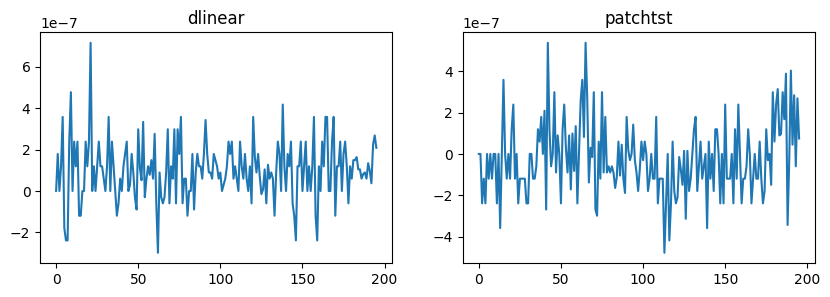

In [ ]:
#how close are the meta predictions with respect to the original ones while using the virutal weights
h=0 #horizon item
v=0 #variate
samples=-1
fig,ax=plt.subplots(1,len(exp_dict.keys()),figsize=(10,3))
for i,model_name in enumerate(exp_dict.keys()):
    num_error=exp_dict[model_name]['pred_test'][:samples,h,v].detach()-exp_dict[model_name]['pred_w'][:samples,h,v]+exp_dict[model_name]['bias'][h,v]
    ax[i].plot(num_error)
    ax[i].set_title(model_name)

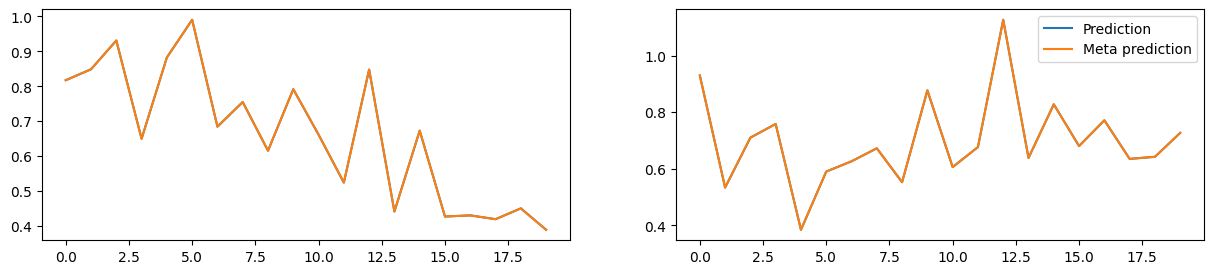

In [ ]:
#visualization of one inference
n=99 #time step
v=0 #variate
fig,ax=plt.subplots(1,len(exp_dict.keys()),figsize=(15,3))
for i,model_name in enumerate(exp_dict.keys()):
    ax[i].plot(exp_dict[model_name]['pred_test'][n,:,v].detach(),label='Prediction')
    ax[i].plot(exp_dict[model_name]['shap_values_test'].sum(axis=1)[n,:,v]-exp_dict[model_name]['bias'][:,v].numpy(),label='Meta prediction') #meta precition is the sum of shap values plus the bias
ax[1].legend()

### **Median of Differences**

The median of differences quantifies the variation in weights between two surrogate linear models across different time steps. In the plot below, this difference is calculated between consecutive time steps as ( w_t - w_{t-1} ). Larger differences indicate that the model's behavior is changing more rapidly.


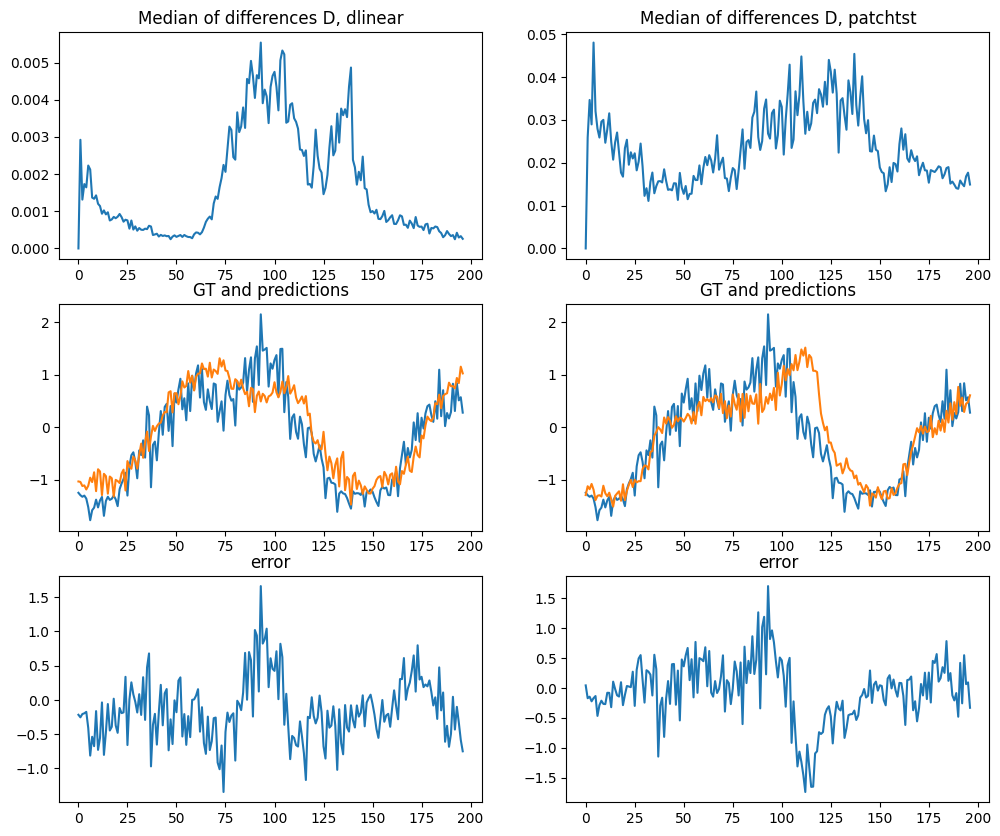

In [22]:
s=200 #time steps
h=10 #horizon item
fig,ax=plt.subplots(3,len(exp_dict.keys()),figsize=(12,10))
for i,model_name in enumerate(exp_dict.keys()):
    ax[0,i].plot(torch.abs(exp_dict[model_name]['xai_matrix'][:s,:,h]).median(dim=1).values)
    ax[0,i].set_title(f'Median of differences D, {model_name}')
    ax[1,i].plot(y_test_rs[:s,h])
    ax[1,i].plot(exp_dict[model_name]['pred_test_rs'][:s,h].detach())
    ax[2,i].plot(exp_dict[model_name]['error_test_rs'][:s,h].detach())
    ax[1,i].set_title('GT and predictions')
    ax[2,i].set_title('error')


## **Variance in a Window of Surrogate Models**

Calculating the variance within a window allows us to assess how virtual weights vary over multiple time steps. This approach helps reduce the dimensionality of the explainer by enabling variance computation across both the horizon and channel dimensions.


/tmp/ipykernel_869533/2502279775.py:11: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  var.append(w_fil[t-window:t,:,h].var(dim=0).mean())
/tmp/ipykernel_869533/2502279775.py:11: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  var.append(w_fil[t-window:t,:,h].var(dim=0).mean())


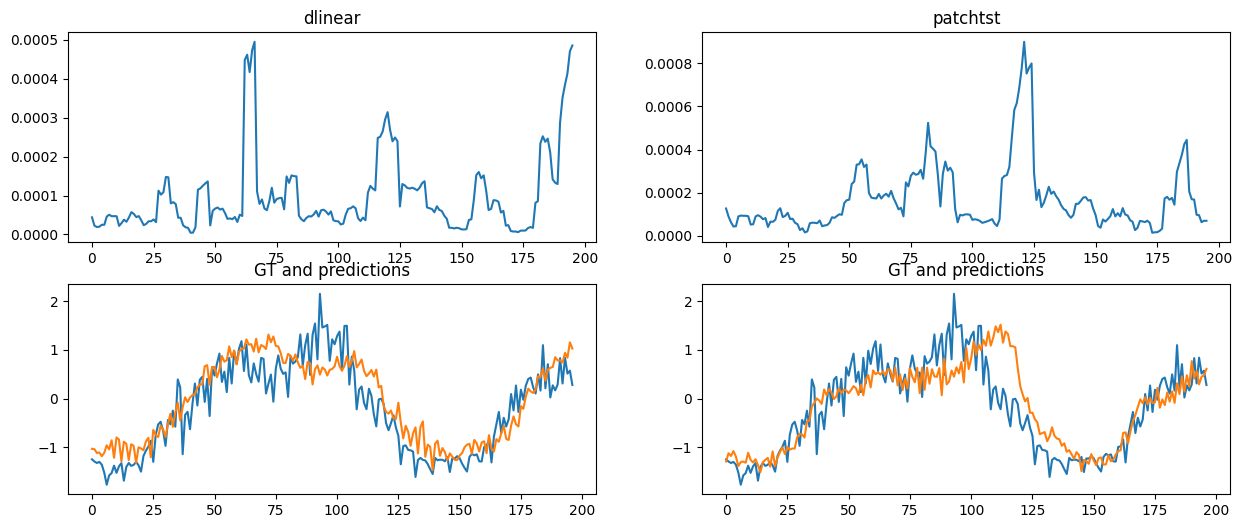

In [39]:
s=200
h=10
window=5
fig,ax=plt.subplots(2,len(exp_dict.keys()),figsize=(15,6))
for i,model_name in enumerate(exp_dict.keys()):
    var=[]
    var_shap=[]
    w_fil=clean_outliers(exp_dict[model_name]['w_matrix'])
    for t in range(s):
        t=t+window
        var.append(w_fil[t-window:t,:,h].var(dim=0).mean())
    ax[0,i].plot(var)
    ax[0,i].set_title(f'{model_name}')
    ax[1,i].plot(y_test_rs[:s,h])
    ax[1,i].plot(exp_dict[model_name]['pred_test_rs'][:s,h].detach())
    ax[1,i].set_title('GT and predictions')

## **Visualizations**

Text(0.5, 1.0, 'dataset: users_bs3, h_i:0')

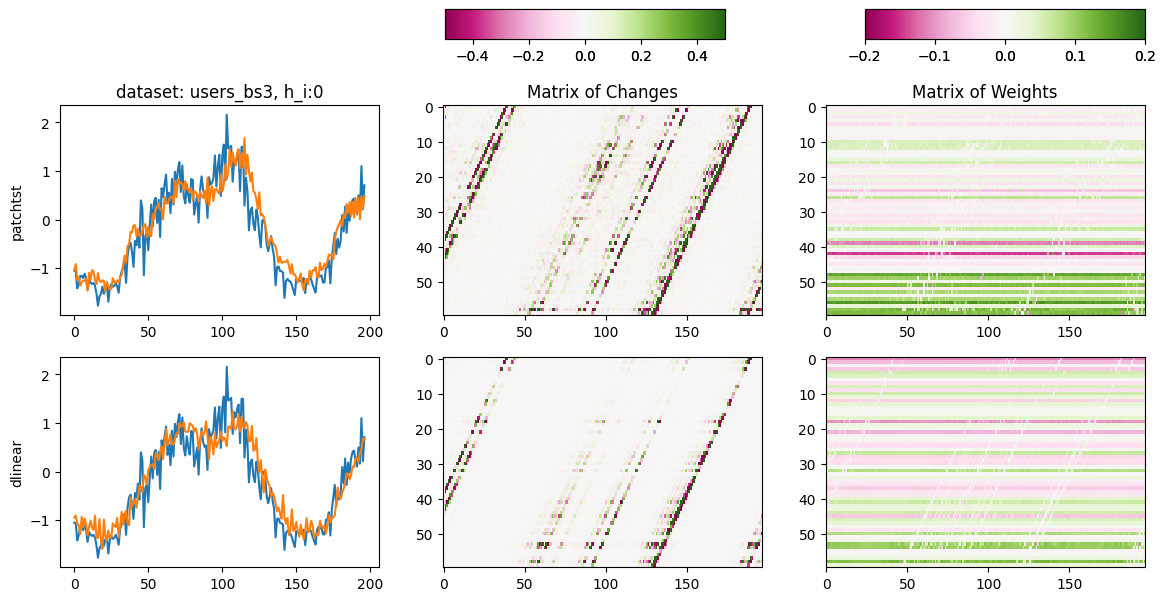

In [54]:
d=[0,200]
v=0
list_models=['patchtst','dlinear']
#list_models=exp_dict.keys()
fig,ax=plt.subplots(len(list_models),3,figsize=(14,6))
for i,model_name in enumerate(list_models):
    cax = fig.add_axes([0.4, 0.99, 0.2, 0.05])
    cax2 = fig.add_axes([0.7, 0.99, 0.2, 0.05])
    c=ax[i,1].imshow(exp_dict[model_name]['xai_matrix'][d[0]:d[1],:,v].T,aspect='auto',cmap='PiYG',interpolation='None',vmin=-.5,vmax=.5)
    ax[i,0].plot(y_test_rs[d[0]:d[1],v])
    ax[i,0].plot(exp_dict[model_name]['pred_test_rs'][d[0]:d[1],v].detach())
    c2=ax[i,2].imshow(exp_dict[model_name]['w_matrix'][d[0]:d[1],:,v].T,aspect='auto',cmap='PiYG',interpolation='None',vmin=-0.2,vmax=0.2)
    fig.colorbar(c, cax=cax, orientation='horizontal')
    fig.colorbar(c2, cax=cax2, orientation='horizontal')
    ax[i,0].set_ylabel(f'{model_name}')
ax[0,2].set_title('Matrix of Weights')
ax[0,1].set_title('Matrix of Changes')
ax[0,0].set_title(f'dataset: {dataset}, h_i:{v}')

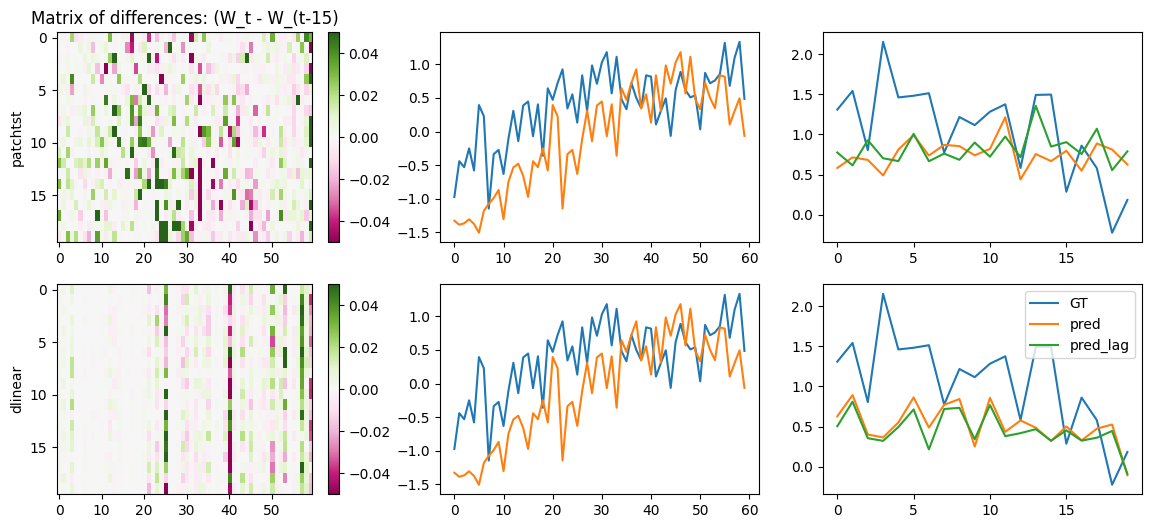

In [56]:
s=100
lag=15
list_models=['patchtst','dlinear']
cl_range=[-.05,.05]
fig,ax=plt.subplots(len(list_models),3,figsize=(14,6))
for i,model_name in enumerate(list_models):
    c=ax[i,0].imshow((exp_dict[model_name]['w_matrix'][s].T-exp_dict[model_name]['w_matrix'][s-lag].T),aspect='auto',vmin=cl_range[0],vmax=cl_range[1],cmap='PiYG')
    ax[i,2].plot(y_test_rs[s,:].float(),label='GT')
    ax[i,0].set_ylabel(model_name)
    ax[i,1].plot(X_test_rs[s])
    ax[i,1].plot(X_test_rs[s-lag])
    ax[i,2].plot(exp_dict[model_name]['pred_test_rs'][s].detach(),label='pred')
    ax[i,2].plot(torch.matmul(clean_outliers(exp_dict[model_name]['w_matrix'],.99).permute(0,2,1).float()[s-lag],X_test_exp[s])[:,0]-exp_dict[model_name]['bias'][:,0].numpy(),label='pred_lag')
    plt.colorbar(c,ax=ax[i,0])
ax[0,0].set_title(f'Matrix of differences: (W_t - W_(t-{lag})')
plt.legend()
tikzplotlib.save('forecasting-lag1-fullh.tex')

## **Analyzing the periodic behavior of virtual weights**
A given sample of virtual weights, 𝑤 is compared with others to measure similarity. Samples with more similar virtual weights yield lower values on the y-axis. This approach is useful for detecting similar patterns as well as identifying anomalies.

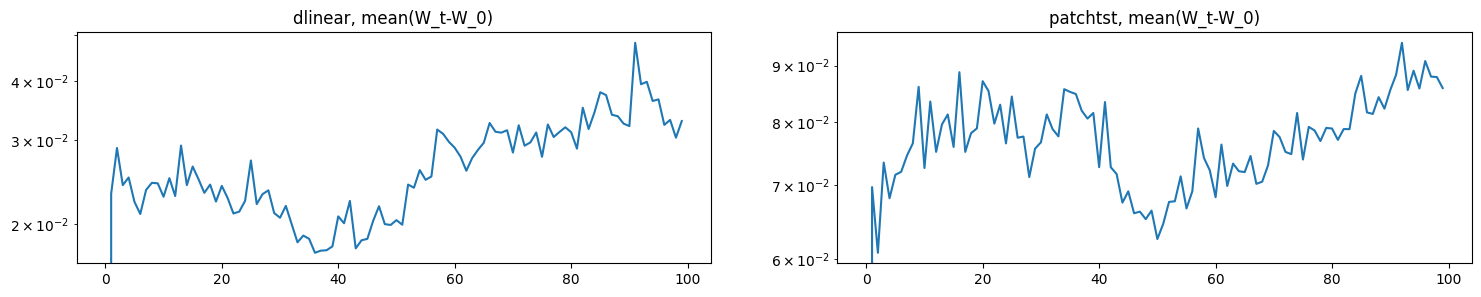

In [3]:
w=0 #sample to compare with
samples=100
fig,ax=plt.subplots(1,len(exp_dict.keys()),figsize=(18,3))
for t,model_name in enumerate(exp_dict.keys()):
     w_fil=clean_outliers(exp_dict[model_name]['w_matrix'],.99)
     diff_list=[]
     for i in range(samples):
        diff_list.append(torch.abs((w_fil[i]-w_fil[w])).mean().item())
     ax[t].plot(diff_list)
     ax[t].set_title(model_name+f', mean(W_t-W_{w})')
     ax[t].set_yscale('log')

## **Displaying the virtual weights for the different models**

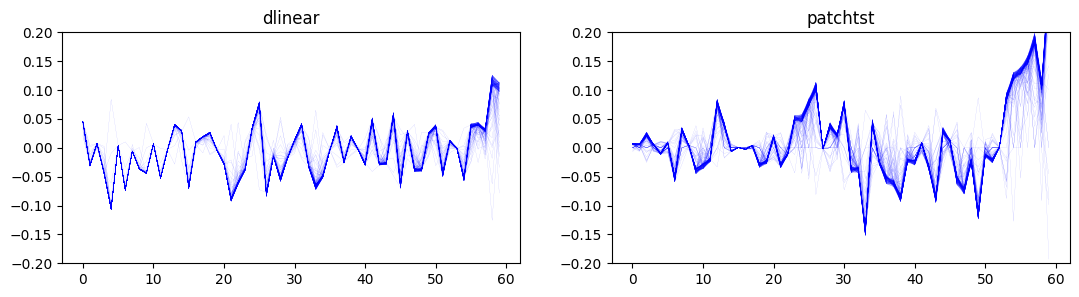

In [ ]:
h=19 #horizon item
fig,ax=plt.subplots(1,len(exp_dict.keys()),figsize=(13,3))
for t,model_name in enumerate(exp_dict.keys()):
    ax[t].set_title(model_name)
    ax[t].plot(exp_dict[model_name]['w_matrix'][:1000,:,h].T,'b',linewidth=0.1,alpha=0.4)
    ax[t].set_ylim(-0.2,0.2)
    #ax[t].set_yscale('log')
plt.show()